In [1]:
import os
import pandas as pd
# import torchaudio
import torch
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
from jiwer import wer
from nltk.translate.bleu_score import sentence_bleu
from tqdm import tqdm

/nfs/home/kog0976/.conda/envs/nlp_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Join data (audio path + text)

In [2]:
# Root path to the unzipped dataset
base_dir = "LibriSpeech/train-clean-100"
output_csv = "full_transcripts.csv"

data = []

# Loop through speaker folders
for speaker_id in os.listdir(base_dir):
    speaker_path = os.path.join(base_dir, speaker_id)
    if not os.path.isdir(speaker_path):
        continue

    # Loop through chapter folders
    for chapter_id in os.listdir(speaker_path):
        chapter_path = os.path.join(speaker_path, chapter_id)
        if not os.path.isdir(chapter_path):
            continue

        # Transcript file
        trans_path = os.path.join(chapter_path, f"{speaker_id}-{chapter_id}.trans.txt")
        if not os.path.exists(trans_path):
            continue

        # Read each line in transcript and match with audio
        with open(trans_path, "r") as f:
            for line in f:
                parts = line.strip().split(" ", 1)
                if len(parts) != 2:
                    continue
                utt_id, text = parts
                flac_path = os.path.join(chapter_path, utt_id + ".flac")
                if os.path.exists(flac_path):
                    data.append({
                        "speaker_id": speaker_id,
                        "chapter_id": chapter_id,
                        "utterance_id": utt_id,
                        "text": text,
                        "audio_path": flac_path
                    })

# Create full DataFrame
df = pd.DataFrame(data)
df.to_csv(output_csv, index=False)

In [3]:
df.head()

### audio to text

In [ ]:
# Load the CSV file
df = pd.read_csv("full_transcripts.csv")

# Initialize the Wav2Vec2 model and processor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h").to("cuda").eval()

# Prepare lists to store results
wer_list = []
bleu_list = []
new_text_list = []

# Process in batches
batch_size = 5
for start in tqdm(range(0, len(df), batch_size), desc="Processing Batches"):
    batch_df = df.iloc[start:start + batch_size]

    # Prepare the batch inputs
    input_values = []
    reference_texts = []
    for _, row in batch_df.iterrows():
        audio_path = row["audio_path"]
        reference_text = row["text"].strip()
        reference_texts.append(reference_text)

        # Load the audio file
        speech_array, sampling_rate = torchaudio.load(audio_path)
        speech_array = speech_array.squeeze().numpy()

        # Resample to 16k if necessary
        if sampling_rate != 16000:
            resampler = torchaudio.transforms.Resample(sampling_rate, 16000)
            speech_array = resampler(torch.tensor(speech_array)).numpy()

        # Append the raw speech data (without padding yet)
        input_values.append(speech_array)

    # Pad and convert to tensor
    inputs = processor(input_values, sampling_rate=16000, return_tensors="pt", padding=True).input_values.to("cuda")

    # Run the batch through the model (with mixed precision for speed)
    with torch.inference_mode(), torch.cuda.amp.autocast():
        logits = model(inputs).logits

    # Decode the transcriptions
    for i, logit in enumerate(logits):
        predicted_ids = torch.argmax(logit, dim=-1)
        transcription = processor.decode(predicted_ids.cpu())

        # Calculate WER
        error_rate = wer(reference_texts[i].lower(), transcription.lower())
        wer_list.append(error_rate)

        # Calculate BLEU
        reference_tokens = [reference_texts[i].lower().split()]
        candidate_tokens = transcription.lower().split()
        bleu_score = sentence_bleu(reference_tokens, candidate_tokens)
        bleu_list.append(bleu_score)

        # Store the transcription
        new_text_list.append(transcription)

        print(f"✅ Processed {batch_df.iloc[i]['audio_path']} (WER: {round(error_rate, 4)}, BLEU: {round(bleu_score, 4)})")

# Add the new transcriptions and error scores as columns
df["new_text"] = new_text_list
df["wer"] = wer_list
df["bleu"] = bleu_list

# Save the updated CSV
df.to_csv("new_full_transcripts.csv", index=False)
print("\n✅ CSV updated with new transcriptions, WER, and BLEU scores.")

# Calculate average WER and BLEU
average_wer = sum(wer_list) / len(wer_list) if wer_list else 0
average_bleu = sum(bleu_list) / len(bleu_list) if bleu_list else 0
print(f"\n📊 Average WER: {round(average_wer, 4)}")
print(f"📊 Average BLEU: {round(average_bleu, 4)}")


### Load Data (After converting auido to text)

In [4]:
full_transcripts = pd.read_csv('new_full_transcripts.csv')

In [5]:
full_transcripts.shape

(28539, 8)

In [6]:
full_transcripts.head()

,speaker_id,chapter_id,utterance_id,text,audio_path,new_text,wer,bleu
0,3374,298026,3374-298026-0000,IT LOOKS AT ME JOYOUSLY OUT OF ITS DEEP EYES A...,train-clean-100/3374/298026/3374-298026-0000.flac,IT LOOKS AT ME JOYOUSLY OUT OF ITS DEEP EYES A...,0.0,1.0
1,3374,298026,3374-298026-0001,THE HOLIEST AND MOST EVANESCENT OF THOSE DELIC...,train-clean-100/3374/298026/3374-298026-0001.flac,THE HOLIEST AND MOST EVANESCENT OF THOSE DELIC...,0.0,1.0
2,3374,298026,3374-298026-0002,ARE MERELY THE COMMON ATMOSPHERE OF OUR SPIRIT...,train-clean-100/3374/298026/3374-298026-0002.flac,ARE MERELY THE COMMON ATMOSPHERE OF OUR SPIRIT...,0.0,1.0
3,3374,298026,3374-298026-0003,FURTHERMORE IN THIS THRONG OF IMPRESSIONS I CO...,train-clean-100/3374/298026/3374-298026-0003.flac,FURTHERMORE IN THIS THRONG OF IMPRESSIONS I CO...,0.0,1.0
4,3374,298026,3374-298026-0004,EACH IDEA DEVELOPS A COUNTLESS PROGENY,train-clean-100/3374/298026/3374-298026-0004.flac,EACH IDEA DEVELOPS A COUNTLESS PROGENY,0.0,1.0


#### Remove na for text

In [7]:
full_transcripts.isna().sum()

speaker_id      0
chapter_id      0
utterance_id    0
text            0
audio_path      0
new_text        2
wer             0
bleu            0
dtype: int64

In [8]:
full_transcripts = full_transcripts[full_transcripts['new_text'].notna()]

In [9]:
df = full_transcripts.copy()

In [10]:
from punctuators.models import PunctCapSegModelONNX

# Load model once
punct_model = PunctCapSegModelONNX.from_pretrained("1-800-BAD-CODE/xlm-roberta_punctuation_fullstop_truecase")

def restore_df_text_column(df, text_col="new_text"):
    texts = df[text_col].astype(str).str.lower().tolist()
    restored = punct_model.infer(texts)
    flattened = [" ".join(text) if isinstance(text, list) else str(text) for text in restored]
    df = df.copy()
    df["restored_text"] = flattened
    return df


/nfs/home/kog0976/.conda/envs/nlp_env/lib/python3.10/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:121: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


In [11]:
full_transcripts = restore_df_text_column(full_transcripts, text_col="new_text")
print(full_transcripts[["new_text", "restored_text"]].head())


                                            new_text  \
0  IT LOOKS AT ME JOYOUSLY OUT OF ITS DEEP EYES A...   
1  THE HOLIEST AND MOST EVANESCENT OF THOSE DELIC...   
2  ARE MERELY THE COMMON ATMOSPHERE OF OUR SPIRIT...   
3  FURTHERMORE IN THIS THRONG OF IMPRESSIONS I CO...   
4             EACH IDEA DEVELOPS A COUNTLESS PROGENY   

                                       restored_text  
0  It looks at me joyously out of its deep eyes a...  
1  The holiest and most evanescent of those delic...  
2  Are merely the common atmosphere of our spirit...  
3  Furthermore, in this throng of impressions, I ...  
4            Each idea develops a countless progeny.  


In [15]:
full_transcripts.to_csv("full_transcript_restoredcase.csv")

### Extract name entities from the text

In [19]:
full_transcripts = pd.read_csv("full_transcript_restoredcase.csv")
full_transcripts.head()

,Unnamed: 0,speaker_id,chapter_id,utterance_id,text,audio_path,new_text,wer,bleu,restored_text
0,0,3374,298026,3374-298026-0000,IT LOOKS AT ME JOYOUSLY OUT OF ITS DEEP EYES A...,train-clean-100/3374/298026/3374-298026-0000.flac,IT LOOKS AT ME JOYOUSLY OUT OF ITS DEEP EYES A...,0.0,1.0,It looks at me joyously out of its deep eyes a...
1,1,3374,298026,3374-298026-0001,THE HOLIEST AND MOST EVANESCENT OF THOSE DELIC...,train-clean-100/3374/298026/3374-298026-0001.flac,THE HOLIEST AND MOST EVANESCENT OF THOSE DELIC...,0.0,1.0,The holiest and most evanescent of those delic...
2,2,3374,298026,3374-298026-0002,ARE MERELY THE COMMON ATMOSPHERE OF OUR SPIRIT...,train-clean-100/3374/298026/3374-298026-0002.flac,ARE MERELY THE COMMON ATMOSPHERE OF OUR SPIRIT...,0.0,1.0,Are merely the common atmosphere of our spirit...
3,3,3374,298026,3374-298026-0003,FURTHERMORE IN THIS THRONG OF IMPRESSIONS I CO...,train-clean-100/3374/298026/3374-298026-0003.flac,FURTHERMORE IN THIS THRONG OF IMPRESSIONS I CO...,0.0,1.0,"Furthermore, in this throng of impressions, I ..."
4,4,3374,298026,3374-298026-0004,EACH IDEA DEVELOPS A COUNTLESS PROGENY,train-clean-100/3374/298026/3374-298026-0004.flac,EACH IDEA DEVELOPS A COUNTLESS PROGENY,0.0,1.0,Each idea develops a countless progeny.


In [20]:
import spacy

nlp = spacy.load("en_core_web_sm") 

def extract_ner(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]
    
full_transcripts["entities"] = full_transcripts["restored_text"].apply(extract_ner)
full_transcripts.to_csv("transcripts_with_entities.csv", index=False)

In [21]:
# pip install -U "spacy[cuda-autodetect,transformers]"

In [47]:
full_transcripts["restored_text"][28520]

'And far beyond, it is the Grand Manadnock in Jaffrey.'

In [48]:
import numpy as np
full_transcripts.entities[28520]

[('the Grand Manadnock', 'FAC'), ('Jaffrey', 'GPE')]

In [22]:
full_transcripts[["restored_text", "entities"]].head()

,restored_text,entities
0,It looks at me joyously out of its deep eyes a...,[]
1,The holiest and most evanescent of those delic...,[]
2,Are merely the common atmosphere of our spirit...,[]
3,"Furthermore, in this throng of impressions, I ...",[]
4,Each idea develops a countless progeny.,[]


### Plot related to NER

In [20]:
# full_transcripts = pd.read_csv('transcripts_with_entities.csv')

In [51]:
import ast
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

In [52]:
# Only convert if not already a list
full_transcripts["entities"] = full_transcripts["entities"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

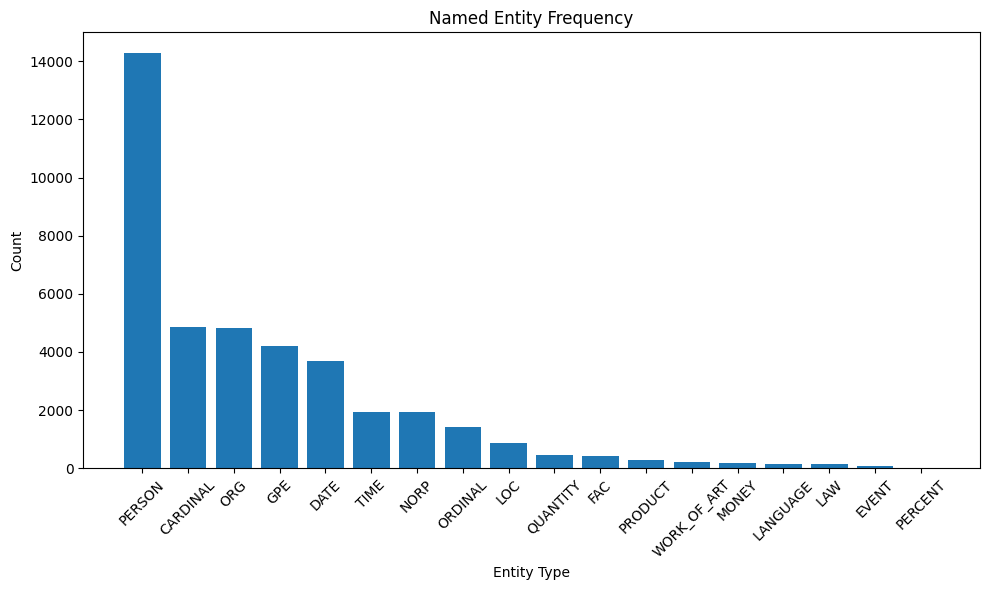

In [53]:
all_entities = []

for row in full_transcripts["entities"].dropna():
    parsed = ast.literal_eval(row) if isinstance(row, str) else row
    all_entities.extend([ent[1] for ent in parsed])

# Count frequency of each entity type
entity_counts = Counter(all_entities)

# Convert to DataFrame for plotting
entity_df = pd.DataFrame(entity_counts.items(), columns=["Entity", "Count"]).sort_values(by="Count", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.bar(entity_df["Entity"], entity_df["Count"])
plt.title("Named Entity Frequency")
plt.xlabel("Entity Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


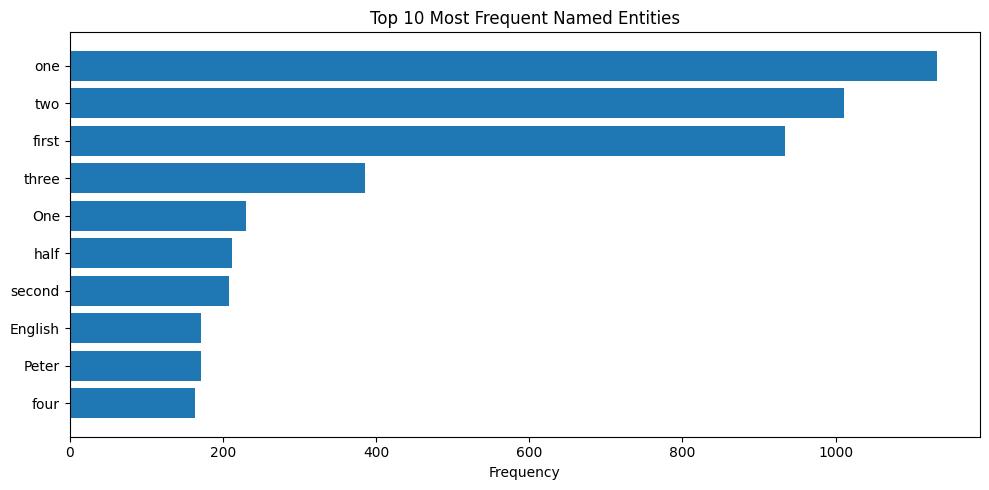

In [54]:
# Flatten to get all entity texts
all_entities = [text for entity_list in full_transcripts["entities"]
                for text, _ in entity_list if isinstance(entity_list, list)]

# Count top 10
entity_counts = Counter(all_entities).most_common(10)

# Plot
texts, counts = zip(*entity_counts)
plt.figure(figsize=(10, 5))
plt.barh(texts, counts)
plt.title("Top 10 Most Frequent Named Entities")
plt.xlabel("Frequency")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [75]:
from spacy import displacy
example_text = full_transcripts["restored_text"].iloc[20000] # e.g: 0 & 20000
doc = nlp(example_text)

options = {"color": "blue", "jupyter": True, "dep": True}
displacy.render(doc, style="dep", options=options)

In [76]:
displacy.render(doc, style="ent", jupyter=True)

### Summarization 

In [77]:
import os
from transformers import pipeline

# Set transformer to avoid TensorFlow usage
os.environ["USE_TF"] = "0"
os.environ["TRANSFORMERS_NO_TF"] = "1"

# Load summarizer model
summarizer = pipeline("summarization", model="google/flan-t5-large", device=0)

Device set to use cuda:0


In [84]:
long_texts.shape
long_texts[6816]

'Such things are so much worse for a man than for a woman. Fanny was not quite prepared to admit this in her own heart, but she made no reply. On that head. I am sure I hope we may be able to be of use to you, she said. If you will only look upon me as an old friend and write to me if you want me.'

In [79]:
# Filter and sample only long entries
long_texts = full_transcripts["restored_text"]
long_texts = long_texts[long_texts.apply(lambda x: len(x.split()) >= 67)]  # Keep only entries with ≥67 words

# Random select
# sample_texts = long_texts.sample(n=10, random_state=123)  # Sample 10
# print(f"Selected {len(sample_texts)} long entries for summarization.")


In [85]:
# Pick the longest transcript to summarize
sample_texts = long_texts

summary_results = []

for text in sample_texts:
    try:
        input_len = len(text.split())

        # Define dynamic summary lengths
        tiny_len = max(5, int(input_len * 0.2))
        short_len = max(10, int(input_len * 0.4))
        long_len = max(25, min(120, int(input_len * 0.8)))

        # Run summaries
        tiny = summarizer(text, max_length=tiny_len, min_length=5, do_sample=False)[0]['summary_text']
        short = summarizer(text, max_length=short_len, min_length=10, do_sample=False)[0]['summary_text']
        long = summarizer(text, max_length=long_len, min_length=20, do_sample=False)[0]['summary_text']

        summary_results.append({
            "original": text,
            "tiny_summary": tiny,
            "short_summary": short,
            "long_summary": long
        })
    
    except Exception as e:
        print("Error summarizing:", e)
        continue

Both `max_new_tokens` (=256) and `max_length`(=13) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=27) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=55) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=13) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both

In [86]:
# Create and show result table
summary_df = pd.DataFrame(summary_results)
summary_df

,original,tiny_summary,short_summary,long_summary
0,Such things are so much worse for a man than f...,Fanny would be glad to be of help.,Fanny would be glad to be of help.,Fanny would be glad to be of help to her frien...
1,"It isn't heavy, I've got all my worldly goods ...","I'm glad you've come, even if it would have be...","I'm glad you've come, even if it would have be...","I'm glad you've come, even if it would have be..."
2,But I'd rather believe that it was out of the ...,I'd rather believe that it was out of the kind...,I'd rather believe that it was out of the kind...,I'd rather believe that it was out of the kind...
3,She said she hadn't time to get sick watching ...,I didn't know whether I'd ever have another op...,I didn't know whether I'd ever have another op...,I wanted to see everything that was to be seen...
4,But it appeared that he had left home to get a...,he left home to get a few Indian scalps and th...,he left home to get a few Indian scalps and th...,he left home to get a few Indian scalps and th...
5,"There was, of course, no legality in the Act, ...","Carl the Great was, in no real sense, the succ...","Carl the Great was, in no real sense, the succ...","Carl the Great was, in no real sense, the succ..."
6,"Though they jeered at him, so he was with Wend...",Peter never noticed he had so much to say abou...,Peter never noticed he had so much to say abou...,Peter never noticed he had so much to say abou...
7,"True, true, cried the colonel. With animation,...",The colonel shook his head in disbelief.,The colonel shook his head in disbelief.,The colonel shook his head in disbelief as he ...
8,The horses came stamping and sliding straight ...,The horses came stamping and sliding straight ...,The horses came stamping and sliding straight ...,The horses came stamping and sliding straight ...


In [94]:
summary_df['original'][0], summary_df['original'][1], summary_df['original'][2]

('Such things are so much worse for a man than for a woman. Fanny was not quite prepared to admit this in her own heart, but she made no reply. On that head. I am sure I hope we may be able to be of use to you, she said. If you will only look upon me as an old friend and write to me if you want me.',
 "It isn't heavy, I've got all my worldly goods in it, but it isn't heavy. And if it isn't carried in just a certain way, the handle pulls out. So I'd better keep it because I know the exact knack of it. It's an extremely old carpet bag. Oh, I'm very glad you've come, even if it would have been nice to sleep in a wild cherry tree.",
 "But I'd rather believe that it was out of the kindness of his heart, wouldn't you? When we got on the train, I felt as if everybody must be looking at me and pitying me. But I just went to work and imagined that I had on the most beautiful pale blue silk dress. Because when you are imagining, you might as well imagine something worth while.")

### Summary for each Chapter

In [96]:
# Group by speaker_id and chapter_id, then concatenate the new_text
grouped_df = full_transcripts.groupby(['speaker_id', 'chapter_id'])['restored_text'].apply(lambda x: ' '.join(x)).reset_index()

# Rename the concatenated column to 'text'
grouped_df.rename(columns={'restored_text': 'text'}, inplace=True)

# Display the result
grouped_df.head()


,speaker_id,chapter_id,text
0,19,198,Northanger Abbey. This little work was finishe...
1,19,227,Chapter Thirty. Catherine's disposition was no...
2,26,495,"In Sixteen, Sixty five, written by a citizen w..."
3,26,496,"It was now mid July and the plague, which had ..."
4,27,123349,"Some of the Scottish emigrants, heated with Re..."


In [97]:
grouped_df.shape

(585, 3)

In [103]:
# Randomly sample 100 rows
grouped_df_5 = grouped_df.sample(n=5, random_state=42)

# Check the shape
grouped_df_5


,speaker_id,chapter_id,text
383,5322,7680,"And Olenin, to please Lukashka, as well as to ..."
422,6000,86686,"Well, well, but the darkness of mankind is unt..."
90,426,122822,"A Jonah day, it really began the night before,..."
472,7059,77897,"Oh, no, I don't care anything about him, said ..."
523,8014,112602,"An oval face, broad above and narrow below, go..."


In [ ]:
import google.generativeai as genai

genai.configure(api_key="")  


In [105]:
model = genai.GenerativeModel(model_name="gemini-1.5-flash")

In [106]:
import time

short_summaries = []
medium_summaries = []
long_summaries = []

for idx, row in grouped_df_100.iterrows():
    print(f"Processing row {idx+1}/{len(grouped_df_100)}...")

    try:
        prompt = f"""
        You will summarize the following passage in **exactly three formats**. Please follow this format strictly:

        Short Summary: [One concise sentence.]
        Medium Summary: [Three to five sentences.]
        Long Summary: [One detailed paragraph with richer insights.]

        Passage:
        {row['text']}
        """

        response = model.generate_content(prompt)
        result = response.text.strip().split('\n')

        # Simple parsing based on keywords
        short = next((line for line in result if 'Short' in line), '').split(':', 1)[-1].strip()
        medium = next((line for line in result if 'Medium' in line), '').split(':', 1)[-1].strip()
        long = next((line for line in result if 'Long' in line), '').split(':', 1)[-1].strip()

        short_summaries.append(short)
        medium_summaries.append(medium)
        long_summaries.append(long)

    except Exception as e:
        print(f"Error at row {idx}: {e}")
        short_summaries.append('')
        medium_summaries.append('')
        long_summaries.append('')

    time.sleep(5)  # Sleep to stay under rate limit


Processing row 384/5...
Processing row 423/5...
Processing row 91/5...
Processing row 473/5...
Processing row 524/5...


In [107]:
grouped_df_5['short_summary'] = short_summaries
grouped_df_5['medium_summary'] = medium_summaries
grouped_df_5['long_summary'] = long_summaries


In [108]:
grouped_df_100.head()

,speaker_id,chapter_id,text,short_summary,medium_summary,long_summary
383,5322,7680,"And Olenin, to please Lukashka, as well as to ...","Olenin, befriending a Cossack named Lukashka, ...","Olenin, enjoying the company of the Cossack Lu...",Olenin's encounter with Lukashka transcends a ...
422,6000,86686,"Well, well, but the darkness of mankind is unt...","Saint Kavin, in disguise, tests King O'Toole's...","King O'Toole, a sportsman, encounters Saint Ka...",This whimsical tale recounts the encounter bet...
90,426,122822,"A Jonah day, it really began the night before,...",Anne Shirley endures a disastrous school day m...,Anne's day starts with a toothache and culmina...,The narrative details a particularly trying da...
472,7059,77897,"Oh, no, I don't care anything about him, said ...",Missus Munger and Annie persuade Missus Wilmin...,Missus Munger and Annie visit Missus Wilmingto...,The passage details a pivotal conversation reg...
523,8014,112602,"An oval face, broad above and narrow below, go...","Ancient Irish fashion and grooming practices, ...","Ancient Irish society, especially the aristocr...","The ancient Irish, particularly those of high ..."


In [109]:
# Save DataFrame to CSV
grouped_df_5.to_csv("transcripts_with_summary_5.csv", index=False)

In [115]:
grouped_df_100

,speaker_id,chapter_id,text,short_summary,medium_summary,long_summary
383,5322,7680,"And Olenin, to please Lukashka, as well as to ...","Olenin, befriending a Cossack named Lukashka, ...","Olenin, enjoying the company of the Cossack Lu...",Olenin's encounter with Lukashka transcends a ...
422,6000,86686,"Well, well, but the darkness of mankind is unt...","Saint Kavin, in disguise, tests King O'Toole's...","King O'Toole, a sportsman, encounters Saint Ka...",This whimsical tale recounts the encounter bet...
90,426,122822,"A Jonah day, it really began the night before,...",Anne Shirley endures a disastrous school day m...,Anne's day starts with a toothache and culmina...,The narrative details a particularly trying da...
472,7059,77897,"Oh, no, I don't care anything about him, said ...",Missus Munger and Annie persuade Missus Wilmin...,Missus Munger and Annie visit Missus Wilmingto...,The passage details a pivotal conversation reg...
523,8014,112602,"An oval face, broad above and narrow below, go...","Ancient Irish fashion and grooming practices, ...","Ancient Irish society, especially the aristocr...","The ancient Irish, particularly those of high ..."


In [119]:
grouped_df_5.loc[383].text

"And Olenin, to please Lukashka, as well as to avoid going back alone through the dark forest, asked the corporal to give Lukashka leave, and the corporal did so. Olenin thought that Lukashka wanted to see Maryanka, and he was also glad of the companionship of such a pleasant looking and sociable cossack, Lukashka and Maryanka. He involuntarily united in his mind, and he found pleasure in thinking about them. He loves Maryanka, thought Olenin and I could love her, and a new and powerful emotion of tenderness overcame him. As they walked homewards together through the dark forest, Lukashka, too, felt happy. Something akin to love made itself felt between these two very different young men. Every time they glanced at one another, they wanted to laugh. By which gate do you enter? asked Olenin. By the middle one. But I'll see you as far as the marsh. After that, you have nothing to fear, Olenin laughed. It's all right. What have I to do? And how can you help? Being afraid? Even we are afra

In [116]:
grouped_df_5.short_summary[383]

'Olenin, befriending a Cossack named Lukashka, unexpectedly gifts him a horse, forging a bond of camaraderie and experiencing a profound sense of belonging in the Cossack village.'

In [120]:
grouped_df_5.medium_summary[383]

"Olenin, enjoying the company of the Cossack Lukashka, develops a strong connection with him.  Their shared walk through the dark forest reveals a budding friendship based on mutual respect and affection.  Moved by his feelings, Olenin gifts Lukashka a horse, solidifying their bond.  This act brings Olenin immense happiness and a newfound sense of belonging within the Cossack community.  Lukashka's enthusiastic response further strengthens their relationship."

In [121]:
grouped_df_5.long_summary[383]

"Olenin's encounter with Lukashka transcends a simple companionship, evolving into a deep connection forged amidst the backdrop of a Cossack village.  Their shared journey through the forest, marked by laughter and shared anxieties, reveals a mutual affection that goes beyond superficial pleasantries.  The unexpected gift of a horse acts as a catalyst, profoundly impacting both men. For Olenin, it's a gesture born out of a burgeoning sense of belonging and genuine affection for Lukashka and the Cossack way of life. This gift represents more than just material generosity; it embodies Olenin's newfound appreciation for the simplicity and warmth of the Cossack community, contrasting sharply with his own privileged background.  Lukashka's joyous reaction mirrors Olenin's inner transformation, validating his gesture and cementing a bond of mutual respect and shared experiences. The incident underscores Olenin's personal growth and his discovery of happiness not in his own material wealth, b